In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
stock = pd.read_excel(r'data_input.xlsx', sheet_name='Stock', index_col=0)
call_implied_vol = pd.read_excel(r'data_input.xlsx', sheet_name='Call', index_col=0)
stock, call_implied_vol

(               JPM     AAPL     WMT
 Date                               
 2022-12-13  134.08  145.470  147.49
 2022-12-12  134.21  144.490  148.02
 2022-12-09  132.16  142.160  145.31
 2022-12-08  132.88  142.650  148.78
 2022-12-07  131.50  140.940  149.11
 ...            ...      ...     ...
 2005-06-22   36.26    1.377   48.79
 2005-06-21   36.04    1.352   48.53
 2005-06-20   36.05    1.343   48.86
 2005-06-17   36.08    1.368   48.93
 2005-06-16   35.90    1.356   49.35
 
 [4405 rows x 3 columns],
                JPM    AAPL     WMT
 Date                              
 2022-12-13     NaN  33.831     NaN
 2022-12-12  28.685  33.878  23.336
 2022-12-09  29.418  34.407  23.706
 2022-12-08  29.037  34.334  23.037
 2022-12-07  29.658  34.771  23.019
 ...            ...     ...     ...
 2005-06-22  17.069  39.980  17.680
 2005-06-21  17.102  39.678  17.749
 2005-06-20  17.728  40.363  17.628
 2005-06-17  17.792  41.014  17.905
 2005-06-16  18.267  41.087  17.861
 
 [4405 rows x 3 colum

In [3]:
price = stock.copy()
# p1 = price.multiply(np.array([1, 2, 3]), axis=1).sum(axis=1)
# p2 = price.multiply(np.array([3, 2, -1]), axis=1).sum(axis=1)
# price['P1'] = p1#, price['P2'] = p1, p2
log_rtn = (np.log(price)-np.log(price.shift(-1))).iloc[:-1]
abs_chg = (price-price.shift(-1)).iloc[:-1]
log_rtn

,JPM
Date,
2022-12-13,-0.000969
2022-12-12,0.015392
2022-12-09,-0.005433
2022-12-08,0.010440
2022-12-07,-0.000684
...,...
2005-06-23,-0.009143
2005-06-22,0.006086
2005-06-21,-0.000277


In [4]:
def Historical_Calibration(log_rtn, window):
    sample_mu = log_rtn.rolling(window, min_periods=window).mean().shift(-window+1).iloc[:-window+1]
    sample_vol = log_rtn.rolling(window, min_periods=window).std().shift(-window+1).iloc[:-window+1]

    vol = sample_vol*np.sqrt(252)
    mu = 252*sample_mu+np.square(vol)/2
    return mu, vol

def Expweight_Calibration(log_rtn, lambda_):
    weight = pd.Series(np.power(lambda_, range(len(log_rtn))), name="weight", index=log_rtn.index)
    wgt_log_rtn = log_rtn.mul(weight.values, axis=0)
    log_rtn_sq = np.square(log_rtn)
    wgt_log_rtn_sq = log_rtn_sq.mul(weight.values, axis=0)
    
    wgt_sample_mu = log_rtn.copy()
    wgt_sample_mu.loc[:] = np.nan
    wgt_sample_sq_mu = wgt_sample_mu.copy()
    
    for i in range(len(weight)):
        wgt_sum = weight[i:].sum()
        wgt_sample_mu.iloc[i] = wgt_log_rtn[i:].sum()/wgt_sum
        wgt_sample_sq_mu.iloc[i] = wgt_log_rtn_sq[i:].sum()/wgt_sum
    
    wgt_sample_vol = np.sqrt(wgt_sample_sq_mu - np.square(wgt_sample_mu))
    wgt_vol = wgt_sample_vol*np.sqrt(252)
    wgt_mu = 252*wgt_sample_mu+np.square(wgt_vol)/2
    
    return wgt_vol, wgt_mu

def Parametric_VaR(mu, vol, s0=10000, t_years=5/252, pvar=0.99, direction=['long', 'short']):
    var = dict.fromkeys(direction)
    if 'long' in direction:
        x = vol*np.sqrt(t_years)*norm.ppf(1-pvar)+(mu-vol**2/2)*t_years
        var['long'] = s0*(1-np.exp(x))
    if 'short' in direction:
        x = vol*np.sqrt(t_years)*norm.ppf(pvar)+(mu-vol**2/2)*t_years
        var['short'] = s0*(-1+np.exp(x))
    return pd.concat(var, axis=1, names=['direction', 'equity'])

def Parametric_ES(mu, vol, s0=10000, t_years=5/252, pes=0.975, direction=['long', 'short']):
    es = dict.fromkeys(direction)
    if 'long' in direction:
        x = norm.cdf(norm.ppf(1-pes)-vol*np.sqrt(t_years))
        es['long'] = s0*(1-np.exp(mu*t_years)*x/(1-pes))
    if 'short' in direction:
        x = norm.cdf(-norm.ppf(pes)+vol*np.sqrt(t_years))
        es['short'] = s0*(np.exp(mu*t_years)*x/(1-pes)-1)
    return pd.concat(es, axis=1, names=['direction', 'equity'])

def MonteCarlo_VaRES(mu, vol, s0=10000, t_years=5/252, pvar=0.99, pes=0.975, direction=['long', 'short'], num_sim=100000):
    template = mu.copy()
    template.loc[:] = np.nan
    var = {x: template.copy() for x in direction}
    es = {x: template.copy() for x in direction}
    for i in tqdm(mu.index):
        mu_i = mu.loc[i]
        vol_i = vol.loc[i]
        for col in mu.columns:
            w = np.random.normal(0, 1, num_sim)
            loss = s0 - s0*np.exp((mu_i[col]-vol_i[col]**2/2)*t_years+vol_i[col]*t_years**0.5*w)
            if 'long' in direction:
                var['long'].loc[i, col] = np.quantile(loss, pvar)
                es['long'].loc[i, col] = np.mean(loss[loss>np.quantile(loss, pes)])
            if 'short' in direction:
                var['short'].loc[i, col] = np.quantile(-loss, pvar)
                es['short'].loc[i, col] = np.mean((-loss)[(-loss)>np.quantile(-loss, pes)])
    return pd.concat(var, axis=1, names=['direction', 'equity']), pd.concat(es, axis=1, names=['direction', 'equity'])

def Historical_VaR(log_rtn, s0=10000, t_years=5/252, pvar=0.99, direction=['long', 'short'], window=5*252):
    var = dict.fromkeys(direction)
    t_days = round(t_years*252)
    sums = log_rtn.rolling(t_days, min_periods=t_days).sum().shift(-t_days+1).iloc[:-t_days+1]
    loss = s0-s0*np.exp(sums)
    if 'long' in direction:
        var['long'] = loss.rolling(window, min_periods=window).quantile(pvar).shift(-window+1).iloc[:-window+1]
    if 'short' in direction:
        var['short'] = (-loss).rolling(window, min_periods=window).quantile(pvar).shift(-window+1).iloc[:-window+1]
    return pd.concat(var, axis=1, names=['direction', 'equity'])

def Historical_ES(log_rtn, s0=10000, t_years=5/252, pes=0.975, direction=['long', 'short'], window=5*252):
    template = mu.copy()
    template.loc[:] = np.nan
    es = {x: template.copy() for x in direction}
    t_days = round(t_years*252)
    sums = log_rtn.rolling(t_days).sum().shift(-t_days+1)
    loss = s0-s0*np.exp(sums)
    for i in tqdm(range(len(log_rtn)-window)):
        losstmp = loss.iloc[i:i+window]
        if 'long' in direction:
            es['long'].iloc[i] = np.mean(losstmp[losstmp>np.quantile(losstmp, pes)])
        if 'short' in direction:
            es['short'].iloc[i] = np.mean((-losstmp)[(-losstmp)>np.quantile(-losstmp, pes)])
    return pd.concat(es, axis=1, names=['direction', 'equity'])

def Historical_VaR_abschg(abs_chg, price, s0=10000, t_years=5/252, pvar=0.99, direction=['long', 'short'], window=5*252):
    var = dict.fromkeys(direction)
    t_days = round(t_years*252)
    sums = abs_chg.rolling(t_days, min_periods=t_days).sum().shift(-t_days+1).iloc[:-t_days+1]
    loss = s0*sums/price.reindex_like(sums)
    if 'long' in direction:
        var['long'] = loss.rolling(window, min_periods=window).quantile(pvar).shift(-window+1).iloc[:-window+1]
    if 'short' in direction:
        var['short'] = (-loss).rolling(window, min_periods=window).quantile(pvar).shift(-window+1).iloc[:-window+1]
    return pd.concat(var, axis=1, names=['direction', 'equity'])

def Historical_ES_abschg(abs_chg, price, s0=10000, t_years=5/252, pes=0.975, direction=['long', 'short'], window=5*252):
    template = price.copy()
    template.loc[:] = np.nan
    es = {x: template.copy() for x in direction}
    t_days = round(t_years*252)
    sums = abs_chg.rolling(t_days, min_periods=t_days).sum().shift(-t_days+1).iloc[:-t_days+1]
    loss = s0*sums/price.reindex_like(sums)
    for i in tqdm(range(len(log_rtn)-window)):
        losstmp = loss.iloc[i:i+window]
        if 'long' in direction:
            es['long'].iloc[i] = np.mean(losstmp[losstmp>np.quantile(losstmp, pes)])
        if 'short' in direction:
            es['short'].iloc[i] = np.mean((-losstmp)[(-losstmp)>np.quantile(-losstmp, pes)])
    return pd.concat(es, axis=1, names=['direction', 'equity'])

def Standard_Plot(data, title=None, threshold=[], savepath=None):
    sns.set()
    fig, ax = plt.subplots()
    data.plot(grid=True, figsize=(8, 6), fontsize=12, ax=ax)
    for num in threshold:
        plt.plot(data.index, [num]*len(data), "--", label=num)
    if title is not None: plt.title(title)
    plt.legend()
    plt.show()
    if savepath is not None: fig.savefig(savepath)
    return fig, ax

# Backtesting
def Actual_Loss(price, s0=10000, t_years=5/252, direction=['long', 'short']):
    loss = dict.fromkeys(direction)
    t_days = round(t_years*252)    
    if 'long' in direction:
        loss['long'] = -(s0*price.shift(t_days)/price-s0).iloc[t_days:]
    if 'short' in direction:
        loss['short'] = (s0*price.shift(t_days)/price-s0).iloc[t_days:]
    return pd.concat(loss, axis=1, names=['direction', 'equity'])

def Exceed_Loss(loss, var, window=252):
    newindex = loss.index.intersection(var.index)
    loss, var = loss.reindex(newindex), var.reindex(newindex)
    if len(loss.shape)>1:
        newcolumns = loss.columns.intersection(var.columns)
        loss, var = loss[newcolumns], var[newcolumns]
    exceed = loss.iloc[:-window+1].copy()
    exceed.loc[:] = np.nan
    for i in tqdm(range(len(exceed))):
        exceed.iloc[i] = (loss.iloc[i:i+window]>var.iloc[i]).sum()
    return exceed

# Option
def BS_Delta(underlying, strike, t_years, r, q, vol):
    d1 = (np.log(underlying/strike) + (r-q+0.5*vol**2) * t_years)/(vol*np.sqrt(t_years))
    delta = np.exp(-q*t_years) * norm.cdf(d1)
    return delta

def BS_Price(underlying, strike, t_years, r, q, vol, direction='call'):
    d1 = (np.log(underlying/strike) + (r-q+0.5*vol**2) * t_years)/(vol*np.sqrt(t_years))
    d2 = d1 - vol * np.sqrt(t_years)
    if direction == 'call':
        price = underlying * np.exp(-q*t_years) * norm.cdf(d1) - strike * np.exp(-r*t_years) * norm.cdf(d2)
    else:
        price = strike * np.exp(-r*t_years) * norm.cdf(-d2) - underlying * np.exp(-q*t_years) * norm.cdf(-d1)
    return price

In [ ]:
put0 = BS_price(price, price, 1, r, q, vol0, direction='put')

In [5]:
%%time
mu, vol = Historical_Calibration(log_rtn, 5*252)
mu2, vol2 = Expweight_Calibration(log_rtn, 0.9989)

Wall time: 6.63 s


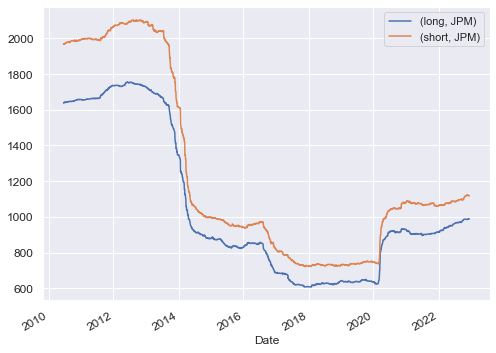

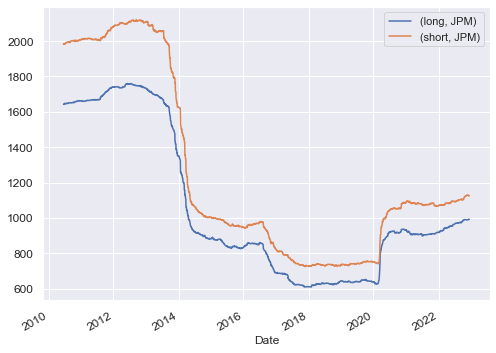

Wall time: 682 ms


((<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>),
 (<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>))

In [6]:
%%time
parametric_var = Parametric_VaR(mu, vol)
parametric_es = Parametric_ES(mu, vol)
Standard_Plot(parametric_var), Standard_Plot(parametric_es)

100%|█████████████████████████████████████████████████████████████████████████████| 3145/3145 [00:05<00:00, 625.01it/s]


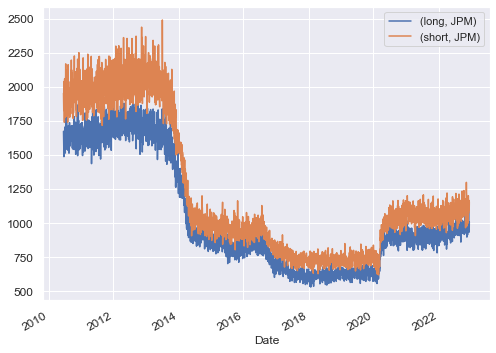

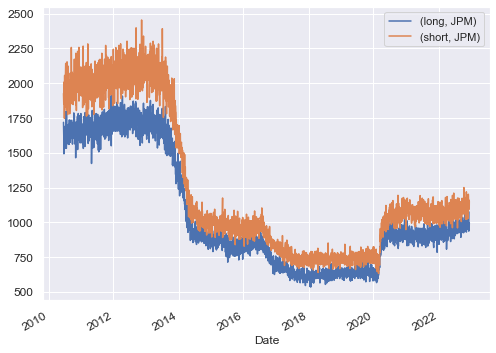

Wall time: 5.89 s


((<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>),
 (<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>))

In [7]:
%%time
montecarlo_var, montecarlo_es = MonteCarlo_VaRES(mu, vol, num_sim=1000)
Standard_Plot(montecarlo_var), Standard_Plot(montecarlo_es)

100%|█████████████████████████████████████████████████████████████████████████████| 3144/3144 [00:09<00:00, 319.58it/s]


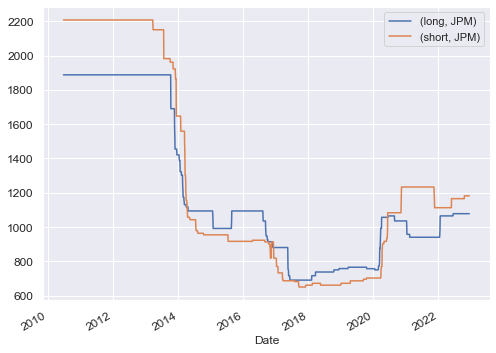

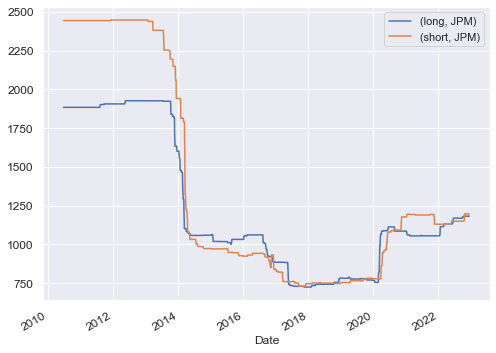

Wall time: 10.5 s


((<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>),
 (<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>))

In [8]:
%%time
historical_var = Historical_VaR(log_rtn)
historical_es = Historical_ES(log_rtn)
Standard_Plot(historical_var), Standard_Plot(historical_es)

100%|█████████████████████████████████████████████████████████████████████████████| 3144/3144 [00:08<00:00, 356.61it/s]


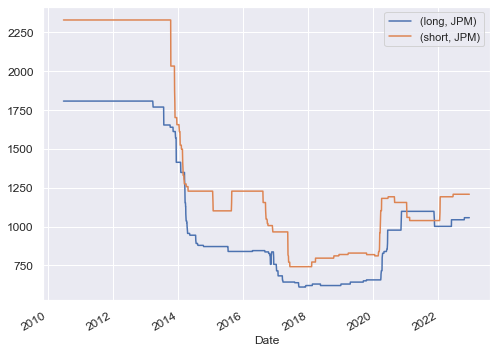

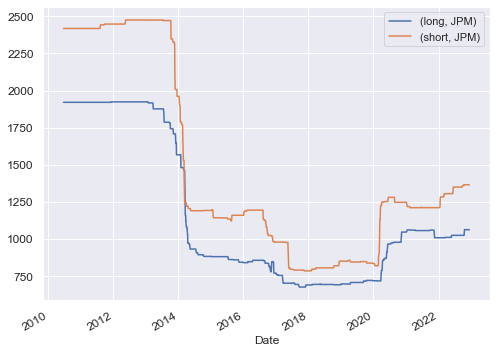

Wall time: 9.55 s


((<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>),
 (<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>))

In [9]:
%%time
historical_var_abs = Historical_VaR_abschg(abs_chg, price)
historical_es_abs = Historical_ES_abschg(abs_chg, price)
Standard_Plot(historical_var_abs), Standard_Plot(historical_es_abs)

100%|█████████████████████████████████████████████████████████████████████████████| 2885/2885 [00:03<00:00, 740.42it/s]


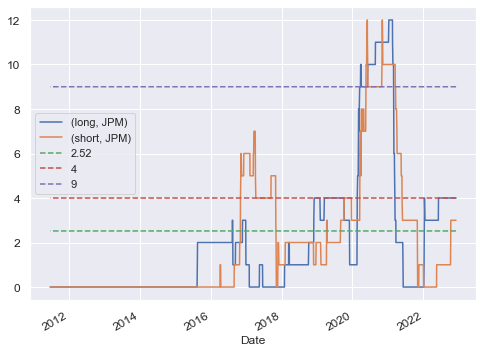

Wall time: 4.3 s


(<Figure size 576x432 with 1 Axes>, <AxesSubplot:xlabel='Date'>)

In [11]:
%%time
actual_loss = Actual_Loss(price)
exceed_loss = Exceed_Loss(actual_loss, historical_var)
Standard_Plot(exceed_loss, threshold=[2.52, 4, 9])